# Impulse Current Calculator - LITE Version

## Quick Usage Guide

**Single universal function for all impulse types:**

```python
run_impulse_calculation(
    impulse_type='PEB',        # 'PEB', 'NEB', 'NFB', 'SEB', or 'SC'
    function_type='heidler',   # 'heidler', 'double_exp', 'both', or 'damped_sine' (for SEB/SC)
    I_peak=200e3,              # Peak current in A (e.g., 200e3 = 200 kA)
    duration='infinity',       # 'infinity' = auto-calculate, or specify in seconds
    dt=1e-8,                   # Time step in seconds (1e-8 = 10 ns)
    show_derivative=False,     # True = show di/dt plot
    compare_functions_flag=False  # True = compare Heidler vs Double-Exp
)
```

**Parameters:**
- `impulse_type`: Impulse designation
  - `PEB` = 10/350 µs (partial lightning current, Type 1 / LPL-related)
  - `SEB` or `SC` = 8/20 µs (surge current, Type 2 / switching/surge-related)
  - `NEB` = 1/200 µs
  - `NFB` = 0.25/100 µs
- `function_type`: Waveform model (Heidler or double-exponential; SEB/SC uses damped_sine)
- `I_peak`: Peak current value (if None, uses IEC reference for LPL I)
- `duration`: Simulation time ('infinity' recommended for accurate W/R and Q)
- `dt`: Time step (smaller = more accurate, but slower)
- `show_derivative`: Add di/dt plot to visualize current steepness
- `compare_functions_flag`: Plot both Heidler and double-exp side-by-side

**Output:** Plots + calculated IEC parameters (W/R, Q, di/dt_max)

## Setup (run once)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Parameter database from my dissertation (Table D.1 and D.2)
IMPULSE_PARAMS = {
    'PEB': {
        'name': 'Positive First Stroke (PEB)', 'designation': '10/350 µs',
        'description': 'Partial lightning current, Type 1 / LPL-related',
        'heidler': {'tau1': 18.8e-6, 'tau2': 485e-6, 'eta': 0.93, 'n': 10},
        'double_exp': {'tau1': 4.064e-6, 'tau2': 470.107e-6, 'eta': 0.951}
    },
    'NEB': {
        'name': 'Negative First Stroke (NEB)', 'designation': '1/200 µs',
        'description': 'Negative first stroke',
        'heidler': {'tau1': 1.826e-6, 'tau2': 285e-6, 'eta': 0.988, 'n': 10},
        'double_exp': {'tau1': 0.374e-6, 'tau2': 284.328e-6, 'eta': 0.99}
    },
    'NFB': {
        'name': 'Negative Subsequent Stroke (NFB)', 'designation': '0.25/100 µs',
        'description': 'Negative subsequent stroke',
        'heidler': {'tau1': 0.454e-6, 'tau2': 143.4e-6, 'eta': 0.993, 'n': 10},
        'double_exp': {'tau1': 0.092e-6, 'tau2': 143.134e-6, 'eta': 0.995}
    },
    'SEB': {
        'name': 'Surge Current (SEB)', 'designation': '8/20 µs',
        'description': 'Switching Event / Surge current, Type 2 / switching/surge-related',
        'damped_sine': {'tau': 24e-6, 'omega': 120023, 'eta': 0.615}
    },
    'SC': {
        'name': 'Surge Current (SC)', 'designation': '8/20 µs',
        'description': 'Surge Current, Type 2 / switching/surge-related',
        'damped_sine': {'tau': 24e-6, 'omega': 120023, 'eta': 0.615}
    }
}

REFERENCE_VALUES = {
    'PEB': {'I_peak': 200e3, 'Q': 100, 'W_R': 10e6},
    'NEB': {'I_peak': 100e3, 'Q': 28.7, 'W_R': 1.44e6},
    'NFB': {'I_peak': 50e3, 'Q': 7.2, 'W_R': 0.18e6},
    'SEB': {'I_peak': 10e3, 'Q': 5, 'W_R': 0.05e6},
    'SC': {'I_peak': 10e3, 'Q': 5, 'W_R': 0.05e6}
}

def heidler_function(t, I_peak, tau1, tau2, eta, n=10):
    """Heidler function: i(t) = (I/eta) * (t/tau1)^n / (1 + (t/tau1)^n) * exp(-t/tau2)"""
    t_ratio = t / tau1
    current = (I_peak / eta) * (t_ratio**n / (1 + t_ratio**n)) * np.exp(-t / tau2)
    return current * (I_peak / np.max(current))  # Normalize to exact peak

def double_exp_function(t, I_peak, tau1, tau2, eta):
    """Double-exponential: i(t) = (I/eta) * (exp(-t/tau2) - exp(-t/tau1))"""
    current = (I_peak / eta) * (np.exp(-t / tau2) - np.exp(-t / tau1))
    return current * (I_peak / np.max(current))

def damped_sine_function(t, I_peak, tau, omega, eta):
    """Damped sine wave (SEB/SC): i(t) = (I/eta) * exp(-t/tau) * sin(omega*t)"""
    current = (I_peak / eta) * np.exp(-t / tau) * np.sin(omega * t)
    return current * (I_peak / np.max(current))

def calculate_parameters(t, i, impulse_type=None):
    """Calculate IEC parameters: W/R, Q, di/dt_max"""
    use_abs = (impulse_type in ['SEB', 'SC'])  # For bipolar waveforms
    return {
        'I_peak': np.max(i), 'I_peak_kA': np.max(i)/1e3, 't_peak': t[np.argmax(i)],
        'W_R': np.trapezoid(i**2, t), 'W_R_MJ': np.trapezoid(i**2, t)/1e6,
        'Q': np.trapezoid(np.abs(i) if use_abs else i, t),
        'di_dt_max': np.max(np.gradient(i, t)), 'di_dt_max_kA_us': np.max(np.gradient(i, t))/1e9
    }

def plot_waveform(t, i, title, params, show_derivative=False):
    """Plot current waveform with parameters"""
    fig, axes = plt.subplots(2 if show_derivative else 1, 1, figsize=(12, 8 if show_derivative else 5))
    ax1 = axes[0] if show_derivative else axes
    
    t_us, i_kA = t * 1e6, i / 1e3
    ax1.plot(t_us, i_kA, 'b-', linewidth=2)
    ax1.set_ylabel('Current (kA)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Time (µs)', fontsize=12, fontweight='bold')
    ax1.set_title(title, fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add parameter box
    energy_str = f"{params['W_R_MJ']:.3f} MJ/Ω" if params['W_R_MJ'] >= 1 else f"{params['W_R']/1e3:.2f} kJ/Ω"
    textstr = f"Peak: {params['I_peak_kA']:.2f} kA\nEnergy: {energy_str}\nCharge: {params['Q']:.2f} C\ndi/dt: {params['di_dt_max_kA_us']:.1f} kA/µs"
    ax1.text(0.98, 0.97, textstr, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    if show_derivative:
        di_dt = np.gradient(i, t) / 1e9  # kA/µs
        t_peak = params['t_peak']
        zoom_end = min(t_peak * 3, t[-1])
        zoom_idx = t <= zoom_end
        axes[1].plot(t_us[zoom_idx], di_dt[zoom_idx], 'g-', linewidth=2)
        axes[1].set_xlabel('Time (µs)', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('di/dt (kA/µs)', fontsize=12, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()

def run_impulse_calculation(impulse_type='PEB', function_type='heidler', I_peak=None,
                           duration='infinity', dt=1e-8, show_derivative=False,
                           compare_functions_flag=False):
    """Universal impulse current calculator"""
    # Normalize SC to SEB (both are aliases for 8/20 µs)
    if impulse_type == 'SC':
        impulse_type = 'SEB'
    
    if I_peak is None:
        I_peak = REFERENCE_VALUES[impulse_type]['I_peak']
    
    is_surge = (impulse_type in ['SEB', 'SC'])
    
    if duration == 'infinity':
        multiplier = 7 if not is_surge else 5
        tau_key = 'tau' if is_surge else 'tau2'
        params_key = 'damped_sine' if is_surge else 'heidler'
        duration = multiplier * IMPULSE_PARAMS[impulse_type][params_key][tau_key]
    
    t = np.arange(0, duration, dt)
    results = {}
    
    if is_surge:
        p = IMPULSE_PARAMS[impulse_type]['damped_sine']
        i = damped_sine_function(t, I_peak, p['tau'], p['omega'], p['eta'])
        results['damped_sine'] = calculate_parameters(t, i, impulse_type)
        plot_waveform(t, i, f"{IMPULSE_PARAMS[impulse_type]['name']}", results['damped_sine'], show_derivative)
    else:
        if function_type in ['heidler', 'both']:
            p = IMPULSE_PARAMS[impulse_type]['heidler']
            i_h = heidler_function(t, I_peak, p['tau1'], p['tau2'], p['eta'], p['n'])
            results['heidler'] = calculate_parameters(t, i_h, impulse_type)
            if not compare_functions_flag:
                plot_waveform(t, i_h, f"Heidler: {IMPULSE_PARAMS[impulse_type]['name']}",
                            results['heidler'], show_derivative)
        
        if function_type in ['double_exp', 'both']:
            p = IMPULSE_PARAMS[impulse_type]['double_exp']
            i_d = double_exp_function(t, I_peak, p['tau1'], p['tau2'], p['eta'])
            results['double_exp'] = calculate_parameters(t, i_d, impulse_type)
            if not compare_functions_flag:
                plot_waveform(t, i_d, f"Double-Exp: {IMPULSE_PARAMS[impulse_type]['name']}",
                            results['double_exp'], show_derivative)
        
        if compare_functions_flag and function_type == 'both':
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.plot(t*1e6, i_h/1e3, 'b-', linewidth=2, label='Heidler')
            ax.plot(t*1e6, i_d/1e3, 'r--', linewidth=2, label='Double-Exp')
            ax.set_xlabel('Time (µs)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Current (kA)', fontsize=12, fontweight='bold')
            ax.set_title(f"Comparison: {IMPULSE_PARAMS[impulse_type]['name']}", fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=12)
            
            # Add comparison table
            if results.get('heidler') and results.get('double_exp'):
                params_h = results['heidler']
                params_d = results['double_exp']
                
                # Smart energy display
                if params_h['W_R_MJ'] < 1.0:
                    energy_h_str = f"{params_h['W_R']/1e3:6.2f}"
                    energy_d_str = f"{params_d['W_R']/1e3:6.2f}"
                    energy_unit = "kJ/Ω"
                else:
                    energy_h_str = f"{params_h['W_R_MJ']:6.3f}"
                    energy_d_str = f"{params_d['W_R_MJ']:6.3f}"
                    energy_unit = "MJ/Ω"
                
                # Create comparison text
                textstr = "Parameter Comparison:\n"
                textstr += "-" * 35 + "\n"
                textstr += f"                Heidler    Double-Exp\n"
                textstr += f"Peak (kA):      {params_h['I_peak_kA']:6.2f}     {params_d['I_peak_kA']:6.2f}\n"
                textstr += f"Energy ({energy_unit}): {energy_h_str}     {energy_d_str}\n"
                textstr += f"Charge (C):     {params_h['Q']:6.2f}     {params_d['Q']:6.2f}\n"
                textstr += f"di/dt (kA/µs):  {params_h['di_dt_max_kA_us']:6.1f}     {params_d['di_dt_max_kA_us']:6.1f}"
                
                props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
                ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=9,
                        verticalalignment='top', horizontalalignment='right', bbox=props,
                        fontfamily='monospace')
            
            plt.tight_layout()
    
    plt.show()
    
    # Print results
    print("="*80)
    print(f"{IMPULSE_PARAMS[impulse_type]['name']} - Peak: {I_peak/1e3:.1f} kA")
    print("="*80)
    for name, p in results.items():
        print(f"\n{name.upper().replace('_', ' ')}:")
        print(f"  Peak Current:    {p['I_peak_kA']:.3f} kA")
        print(f"  Specific Energy: {p['W_R_MJ']:.4f} MJ/Ω")
        print(f"  Charge:          {p['Q']:.3f} C")
        print(f"  Max Steepness:   {p['di_dt_max_kA_us']:.2f} kA/µs")
    print("="*80)
    
    return results

print("✓ Calculator ready! Use run_impulse_calculation() below.")

✓ Calculator ready! Use run_impulse_calculation() below.


---
##  Calculation itself

**Modify parameters below and run:**

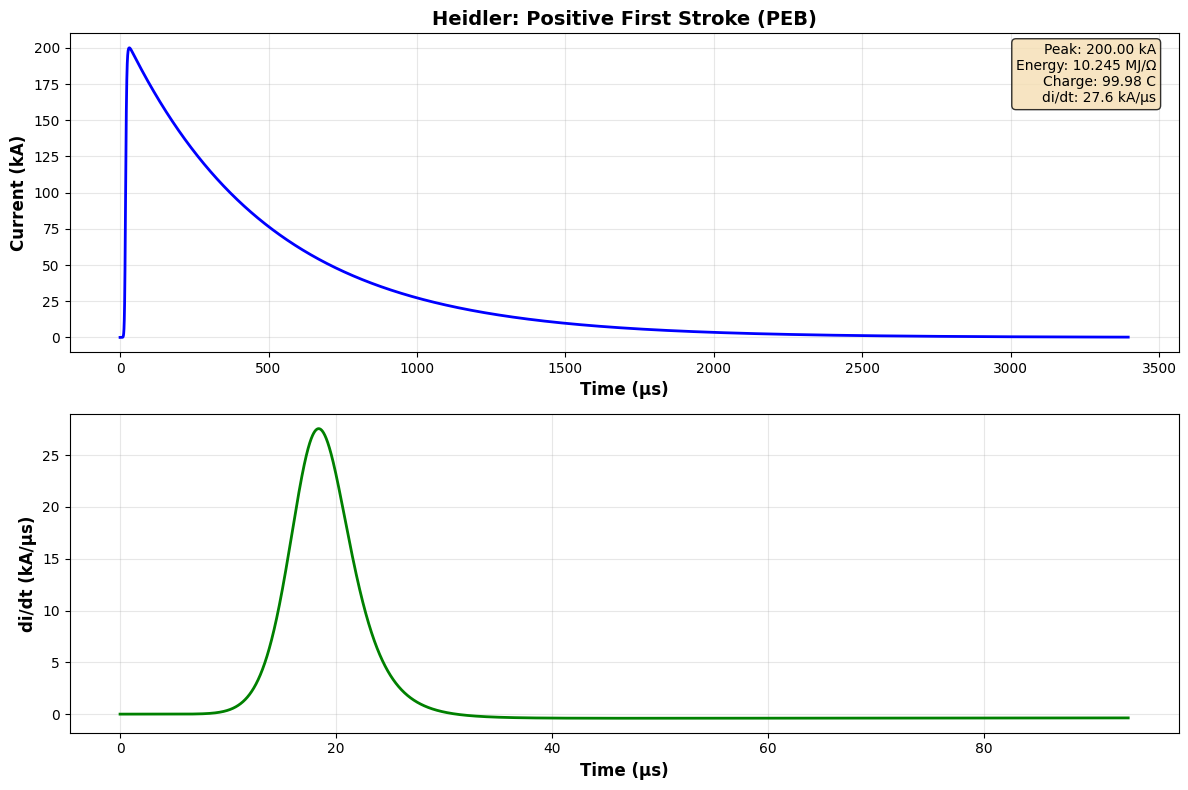

Positive First Stroke (PEB) - Peak: 200.0 kA

HEIDLER:
  Peak Current:    200.000 kA
  Specific Energy: 10.2447 MJ/Ω
  Charge:          99.983 C
  Max Steepness:   27.56 kA/µs


In [17]:
# Customize these parameters for your calculation:

results = run_impulse_calculation(
    impulse_type='PEB',          # Options: 'PEB', 'NEB', 'NFB', 'SEB', 'SC'
    function_type='heidler',     # Options: 'heidler', 'double_exp', 'both', 'damped_sine' (SEB/SC only)
    I_peak=200e3,                # Peak current in Amperes (e.g., 200e3 = 200 kA)
    duration='infinity',         # 'infinity' for auto, or specify in seconds
    dt=1e-8,                     # Time step (1e-8 = 10 ns)
    show_derivative=True,        # Show di/dt plot?
    compare_functions_flag=False # Compare Heidler vs Double-Exp?
)

---
## Example Library

### Example 1: PEB (10/350 µs) - Standard 200 kA

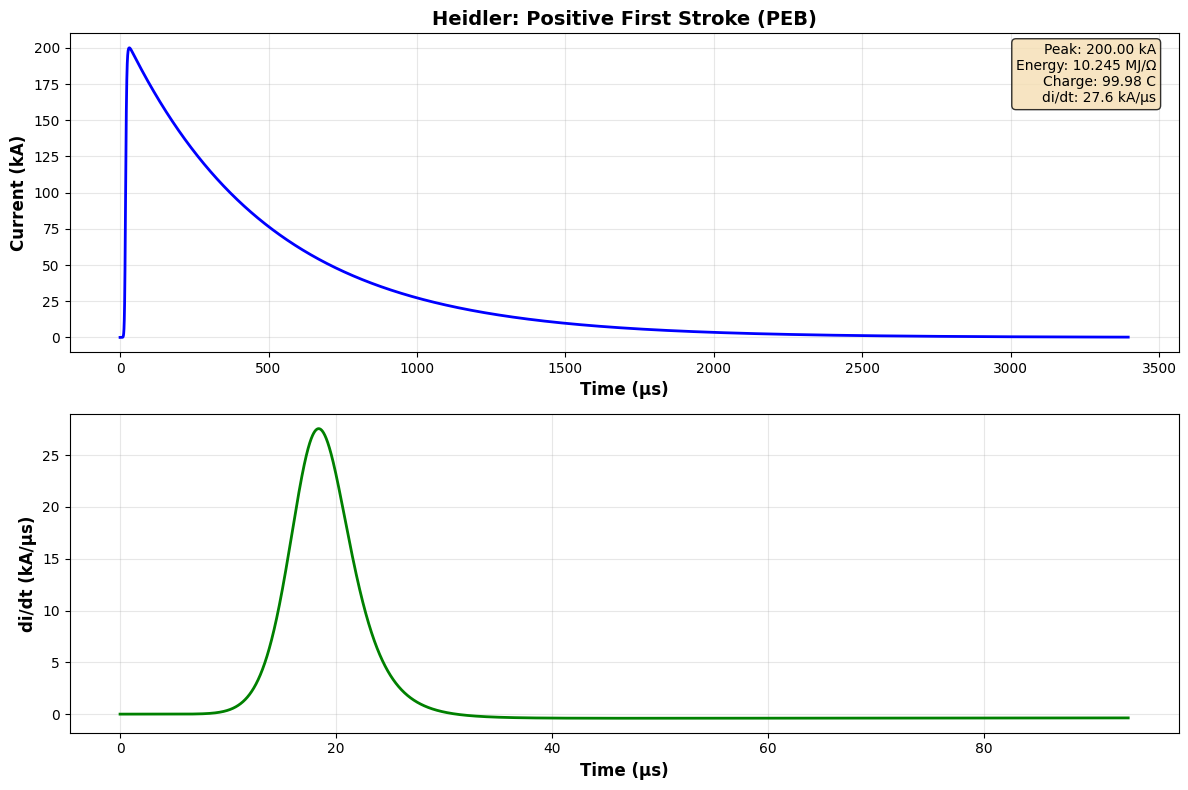

Positive First Stroke (PEB) - Peak: 200.0 kA

HEIDLER:
  Peak Current:    200.000 kA
  Specific Energy: 10.2447 MJ/Ω
  Charge:          99.983 C
  Max Steepness:   27.56 kA/µs


In [18]:
# Standard positive first stroke with derivative plot
ex1 = run_impulse_calculation(
    impulse_type='PEB',
    function_type='heidler',
    I_peak=200e3,
    duration='infinity',
    dt=1e-8,
    show_derivative=True
)

### Example 2: Custom Peak Current (282 kA)

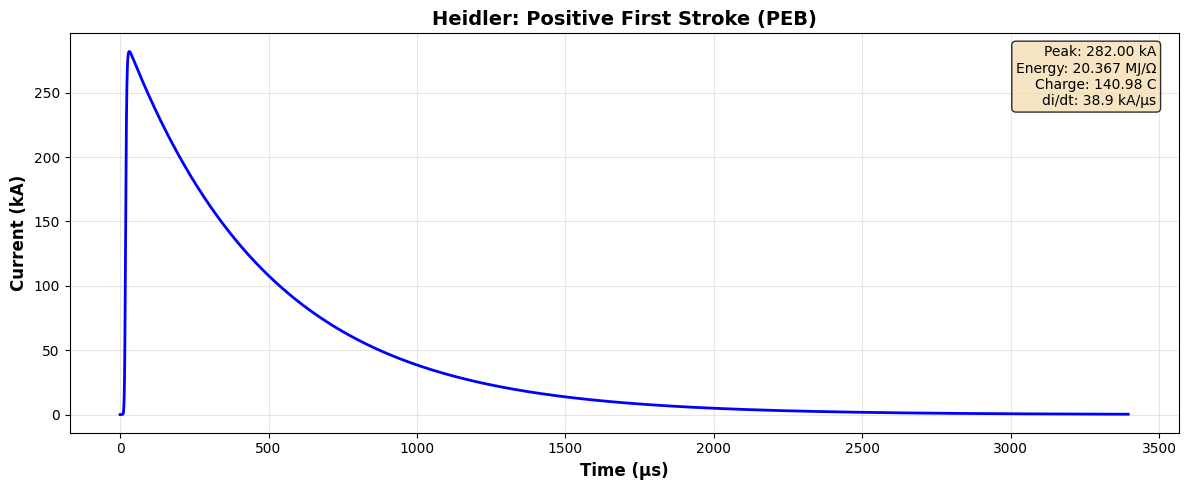

Positive First Stroke (PEB) - Peak: 282.0 kA

HEIDLER:
  Peak Current:    282.000 kA
  Specific Energy: 20.3675 MJ/Ω
  Charge:          140.976 C
  Max Steepness:   38.87 kA/µs


In [19]:
# Custom peak current matching network model
ex2 = run_impulse_calculation(
    impulse_type='PEB',
    function_type='heidler',
    I_peak=282e3,
    duration='infinity',
    dt=1e-8
)

### Example 3: NEB (1/200 µs) - Function Comparison

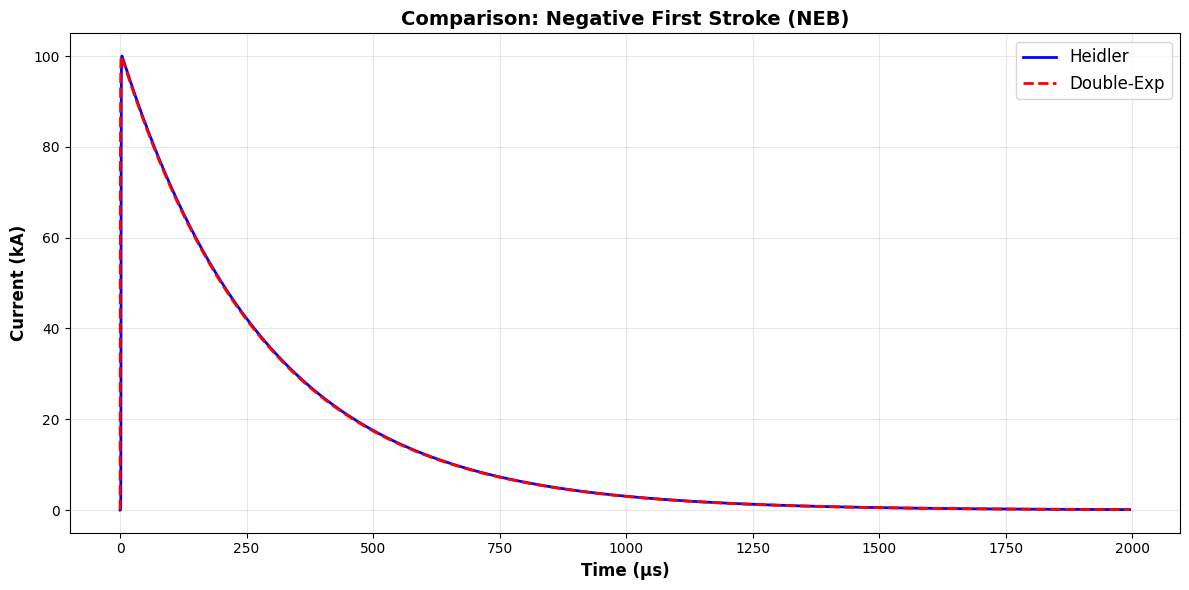

Negative First Stroke (NEB) - Peak: 100.0 kA

HEIDLER:
  Peak Current:    100.000 kA
  Specific Energy: 1.4439 MJ/Ω
  Charge:          28.681 C
  Max Steepness:   139.17 kA/µs

DOUBLE EXP:
  Peak Current:    100.000 kA
  Specific Energy: 1.4448 MJ/Ω
  Charge:          28.657 C
  Max Steepness:   269.37 kA/µs


In [20]:
# Compare Heidler vs Double-Exponential for negative first stroke
ex3 = run_impulse_calculation(
    impulse_type='NEB',
    function_type='both',
    duration='infinity',
    dt=1e-9,  # 1 ns for faster impulse
    compare_functions_flag=True
)

### Example 4: NFB (0.25/100 µs) - Subsequent Stroke

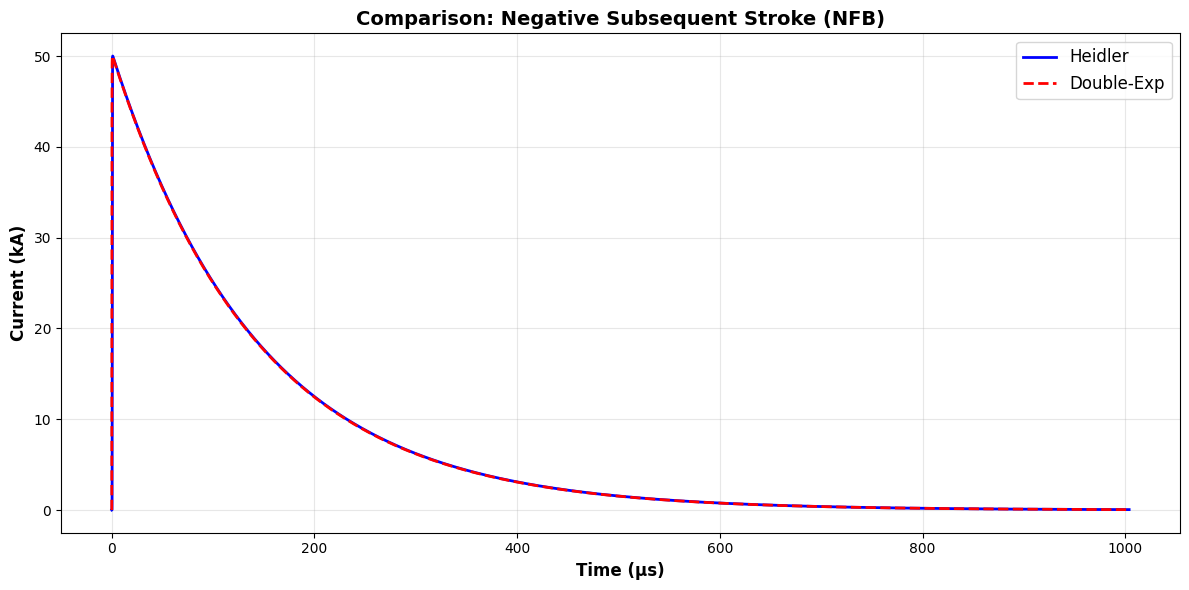

Negative Subsequent Stroke (NFB) - Peak: 50.0 kA

HEIDLER:
  Peak Current:    50.000 kA
  Specific Energy: 0.1806 MJ/Ω
  Charge:          7.192 C
  Max Steepness:   279.09 kA/µs

DOUBLE EXP:
  Peak Current:    50.000 kA
  Specific Energy: 0.1805 MJ/Ω
  Charge:          7.184 C
  Max Steepness:   543.09 kA/µs


In [21]:
# Negative subsequent stroke with both functions
ex4 = run_impulse_calculation(
    impulse_type='NFB',
    function_type='both',
    duration='infinity',
    dt=1e-9,
    compare_functions_flag=True
)

### Example 5: SEB/SC (8/20 µs) - Surge Current

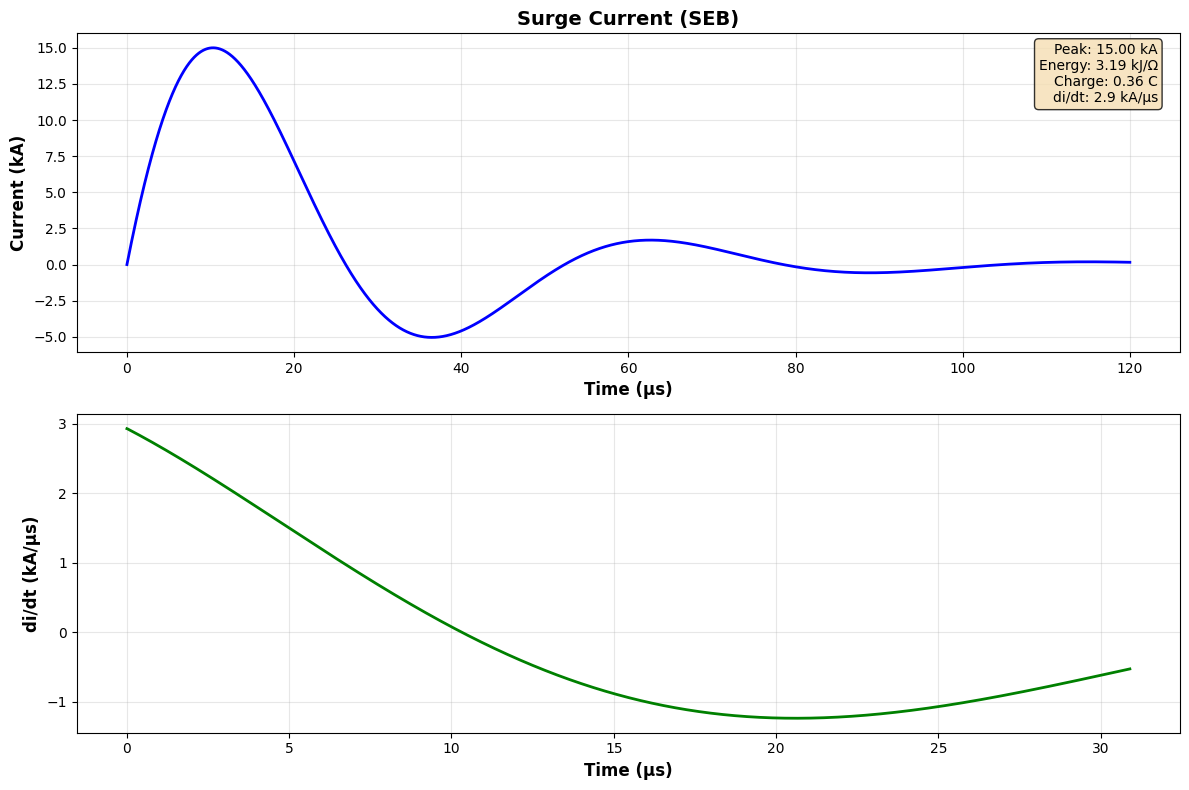

Surge Current (SEB) - Peak: 15.0 kA

DAMPED SINE:
  Peak Current:    15.000 kA
  Specific Energy: 0.0032 MJ/Ω
  Charge:          0.363 C
  Max Steepness:   2.93 kA/µs


In [22]:
# Surge current using damped sine wave (bipolar) - can use 'SEB' or 'SC'
ex5 = run_impulse_calculation(
    impulse_type='SEB',  # or 'SC' - both work
    function_type='damped_sine',
    I_peak=15e3,  # 15 kA
    duration='infinity',
    dt=1e-8,
    show_derivative=True
)